# Analyze open data sets with pandas DataFrames

In this notebook, you'll learn how to use open data from the data sets on the Data Science Experience home page in a Python notebook. You will load, clean, and explore the data with pandas DataFrames. 

Some familiarity with Python is recommended.

The data sets for this notebook are from the World Development Indicators (WDI) data set. The WDI data set is a statistical benchmark that helps measure the progress of human development. The WDI data set draws on data from the World Bank and more than 30 partners. You'll look at seven key development variables, sorted by country and year.

## Learning goals

1. Access data from the Data Science Experience home page.
1. Merge multiple data sets in pandas DataFrames.
1. Structure data for analysis.
1. Generate summary statistics.
1. Create charts with custom formatting.
1. Show relationships between all variables.

In [1]:
# Import Some Modules
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib; matplotlib.style.use('ggplot')

# inline plots
%matplotlib inline

## Table of contents
The main parts of this notebook are:
1. [Load data into DataFrames](#load)
    1. [Load the first data set](#first)
    1. [Load another data set](#loadsecond)
    1. [Join the DataFrames](#joindataframes)
    1. [Add more data](#loadmore)
    1. [Create a MultiIndex](#multiindex)
1. [Check the data](#check)
1. [Analyze the data](#analysis)
    1. [Create scatter plots with matplotlib](#matplotlib)
    1. [Create a scatter plot matrix](#matrix)
1. [Next steps](#summary)

<a id="load"></a>
## 1. Load data into DataFrames

To load the data, you obtain access key links and put them into the code to create pandas DataFrames. You will load data into multiple DataFrames and then merge the DataFrames and create a MultiIndex to structure the data for analysis.

<a id="first"></a>
### A. Load the first data set

The first data set that you'll load contains life expectancy data.

To get your access key link and load the first data set:
1. Find the data set and get the access key link:
    1. On the Data Science Experience home page, search for "life expectancy."
    1. Click the card with the title [Life expectancy at birth by country in total years](https://apsportal.ibm.com/exchange/public/entry/view/f15be429051727172e0d0c226e2ce895).
    1. Click the link button.
    1. Hover above the link button next to the access key to display the link.
    1. Double-click the link to select it, copy the link, and click **Close**.
    1. Insert the access key link and run the cell to load the data:
    1. In the cell below, replace the **LINK-TO-DATA** string in the `read_csv()` method with the link.
    1. Run the following cell to import the pandas and numpy libraries, rename and load three columns of the data into the DataFrame, and show the first five rows of data.

In [2]:
# life expectancy at birth in years
life = pd.read_csv("data/UNdata_life_expectancy_at_birth_total_years.csv",usecols=['Country or Area','Year','Value'])
life.columns = ['country','year','life']
life.head(20)

,country,year,life
0,Afghanistan,2012,60.509122
1,Afghanistan,2011,60.065366
2,Afghanistan,2010,59.600098
3,Afghanistan,2009,59.112341
4,Afghanistan,2008,58.607098
5,Afghanistan,2007,58.091366
6,Afghanistan,2006,57.570659
7,Afghanistan,2005,57.058439
8,Afghanistan,2004,56.569732
9,Afghanistan,2003,56.107561


<a id="loadsecond"></a>
### B. Load another data set

The life expectancy figures are more meaningful if you combine them with other data sets. Get an access key link for this data set: [Total population by country](https://apsportal.ibm.com/exchange/public/entry/view/889ca053a19986a4445839358a91963e). Paste your link in the following cell, which loads three columns of the data and prints the number of countries in each data set: 

In [3]:
# population
population = pd.read_csv("data/UNdata_population_total.csv",usecols=['Country or Area', 'Year','Value'])
population.columns = ['country', 'year','population']
population.head(5)

,country,year,population
0,Afghanistan,2013,30551674.0
1,Afghanistan,2012,29824536.0
2,Afghanistan,2011,29105480.0
3,Afghanistan,2010,28397812.0
4,Afghanistan,2009,27708187.0


In [4]:
print "Nr of countries in life:", np.size(np.unique(life['country']))
print "Nr of countries in population:", np.size(np.unique(population['country']))

Nr of countries in life: 246
Nr of countries in population: 245


In [5]:
life.year.dtype

dtype('O')

In [6]:
population.year.dtype

dtype('int64')

### Masking and Data Scrubbing
Data is sometimes (ALWAYS) dirty. To make analysis easy, we have to first "scrub" them
* Remove Bad entries
* Filter/ Fill missing NAN values (or not!)

In [7]:
# Using masks and apply lambda functions!
# A mask is just a boolean dataframe/series with dimensions of the original dataframe

life[life.year.apply(lambda x: not x.isdigit())].head()

,country,year,life
11969,footnoteSeqID,Footnote,NaN
11970,2,Derived using linearly extrapolated data,NaN
11971,3,Derived using linearly interpolated data,NaN
11972,4,Derived using extrapolated data assuming the s...,NaN
11973,5,Derived using interpolated data,NaN


In [8]:
# Remove non-numeric rows!
life = life[life.year.apply(lambda x: x.isdigit())]

In [9]:
# Change to Float (preferred numeric format of dataframe)
life['year'] = life['year'].astype(float)
population['year'] = population['year'].astype(float)

In [10]:
life.info()
print ""
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11969 entries, 0 to 11968
Data columns (total 3 columns):
country    11969 non-null object
year       11969 non-null float64
life       11969 non-null float64
dtypes: float64(2), object(1)
memory usage: 374.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13121 entries, 0 to 13120
Data columns (total 3 columns):
country       13121 non-null object
year          13121 non-null float64
population    13091 non-null float64
dtypes: float64(2), object(1)
memory usage: 307.6+ KB


## Join DataFrames

As you can see, the two data sets don't fit together perfectly: one contains more countries than the other. When you join two DataFrames, it's common to introduce nulls or NaNs (a value that's not a number when a number is expected) into the resulting DataFrame. 

Use the pandas `merge` function to make the data fit together. In the following cell, the `how='outer'` option specifies to keep the data from the `life` and `population` columns. The `on=['country','year']` option specifies which columns to merge on. To view the options for the `merge` function, see [Merge, join, and concatentate](http://pandas.pydata.org/pandas-docs/stable/merging.html). 

In [11]:
df = pd.merge(life, population, how='outer', sort=True, on=['country','year'])

In [12]:
# Check integrity of data
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13124 entries, 0 to 13123
Data columns (total 4 columns):
country       13124 non-null object
year          13124 non-null float64
life          11969 non-null float64
population    13091 non-null float64
dtypes: float64(3), object(1)
memory usage: 512.7+ KB


country          0
year             0
life          1155
population      33
dtype: int64

In [13]:
df.head()

,country,year,life,population
0,Afghanistan,1960.0,31.580049,8774440.0
1,Afghanistan,1961.0,32.095976,8953544.0
2,Afghanistan,1962.0,32.611878,9141783.0
3,Afghanistan,1963.0,33.127317,9339507.0
4,Afghanistan,1964.0,33.641244,9547131.0


In [14]:
df.groupby("country").mean().sort_values("population", ascending = False).head(10)

,year,life,population
country,,,
World,1986.5,63.752502,5.008097e+09
Low & middle income,1986.5,60.697168,3.904088e+09
Middle income,1986.5,61.954126,3.418550e+09
Upper middle income,1986.5,65.769969,1.778217e+09
East Asia & Pacific (all income levels),1986.5,66.344457,1.695653e+09
Lower middle income,1986.5,57.737533,1.640333e+09
East Asia & Pacific (developing only),1986.5,65.107053,1.490551e+09
High income,1986.5,73.603806,1.104008e+09
South Asia,1986.5,56.502828,1.078283e+09


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13124 entries, 0 to 13123
Data columns (total 4 columns):
country       13124 non-null object
year          13124 non-null float64
life          11969 non-null float64
population    13091 non-null float64
dtypes: float64(3), object(1)
memory usage: 512.7+ KB


In [16]:
# We Need More Lemon Pledge!
countries_filter = pd.read_csv("data/countries.csv",usecols=['English Name'])
countries_filter = countries_filter['English Name'].unique()
df = df[df['country'].apply(lambda x: x in countries_filter)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9952 entries, 0 to 13123
Data columns (total 4 columns):
country       9952 non-null object
year          9952 non-null float64
life          8979 non-null float64
population    9919 non-null float64
dtypes: float64(3), object(1)
memory usage: 388.8+ KB


In [17]:
df = df.reset_index().drop("index", axis = 1)

### This is getting boring..... Lets PLOT something

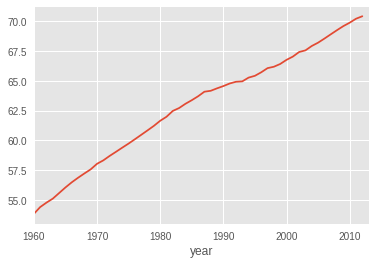

In [18]:
df.groupby('year').mean()['life'].plot()
plt.show()

In [19]:
avg_life = df.drop("year", axis = 1).groupby("country").mean().sort_values("life", ascending = False)
avg_life.head(14)

,life,population
country,,
San Marino,81.494746,2.348367e+04
Liechtenstein,79.796534,2.754563e+04
Iceland,77.495377,2.479294e+05
Isle of Man,77.247561,6.739013e+04
Sweden,77.157326,8.490987e+06
Japan,77.107230,1.171442e+08
Bermuda,77.011644,5.729831e+04
Switzerland,76.807119,6.688197e+06
Norway,76.661077,4.226021e+06


In [20]:
avg_life.tail(20)

,life,population
country,,
Rwanda,45.709723,6.328390e+06
Guinea,45.239984,6.447129e+06
Malawi,45.063332,8.470915e+06
Nigeria,45.012043,9.415954e+07
Chad,44.755199,6.303956e+06
Central African Republic,44.615013,2.813273e+06
Equatorial Guinea,44.479256,3.957122e+05
Niger,43.852782,8.202466e+06
Mozambique,43.275768,1.451595e+07


In [21]:
median_life = df[['year','life']].groupby("year").mean()
median_life.loc[1960][0]

53.810140611225371

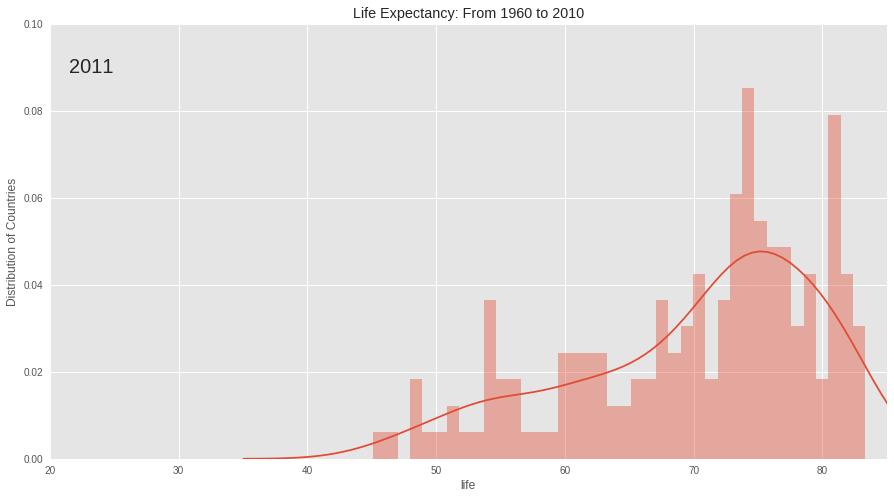

In [22]:
# Line plots are boring. How about a histogram?
import time, sys
from IPython.display import clear_output, display
from pylab import text

f, ax = plt.subplots(figsize = (15,8))

for year in range(1960,2012):
    ax.set_xlim([20,85])
    ax.set_ylim([0,0.1])
    plt.xlabel('Life Expectancy');
    plt.ylabel('Distribution of Countries');
    plt.title('Life Expectancy: From 1960 to 2010')
    text(0.05, 0.9, str(year), fontsize=20,ha='center', va='center', transform=ax.transAxes)

    data = df[df.year == year]["life"].dropna()
    sns.distplot(data,hist=True, kde=True, rug=False, bins=40);
    
#     year_df = df[df.year == year]
#     median  = median_life.loc[year][0]
#     data_low = year_df[year_df.life <= median]["life"].dropna()
#     data_high = year_df[year_df.life > median]["life"].dropna()
#     sns.distplot(data_low,hist=True, kde=True, rug=False, bins=30);
#     sns.distplot(data_high,hist=True, kde=True, rug=False, bins=30);
    
    time.sleep(0.0001)
    clear_output(True)
    display(f)
    ax.cla()

plt.close()

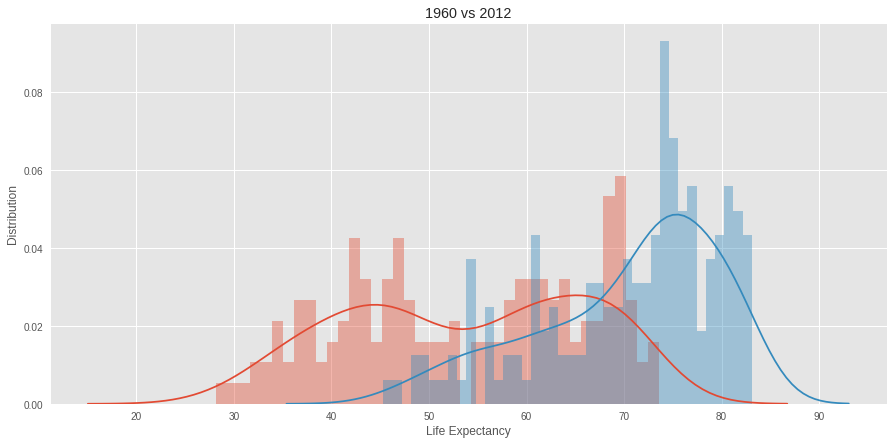

In [23]:
def hist_plot(year1, year2):
    f, ax = plt.subplots(figsize = (15,7))
    clear_output(True)
    ax.cla()
    data1 = df[df.year == year1]["life"].dropna()
    data2 = df[df.year == year2]["life"].dropna()
    sns.distplot(data1,hist=True, kde=True, rug=False, bins=40);
    sns.distplot(data2,hist=True, kde=True, rug=False, bins=40);
    
    plt.xlabel('Life Expectancy')
    plt.ylabel('Distribution')
    plt.title(str(year1) + " vs " + str(year2))
    
hist_plot(1960, 2012)

In [24]:
years = [year for year in range(int(df.year.min()),int(df.year.max())) if year%10==0]
years

[1960, 1970, 1980, 1990, 2000, 2010]

In [25]:
# use list comprehension to to extract decades (Uncomment to try, but might be messy)

from ipywidgets import interact
#interact(hist_plot, year1 =years, year2 =years)

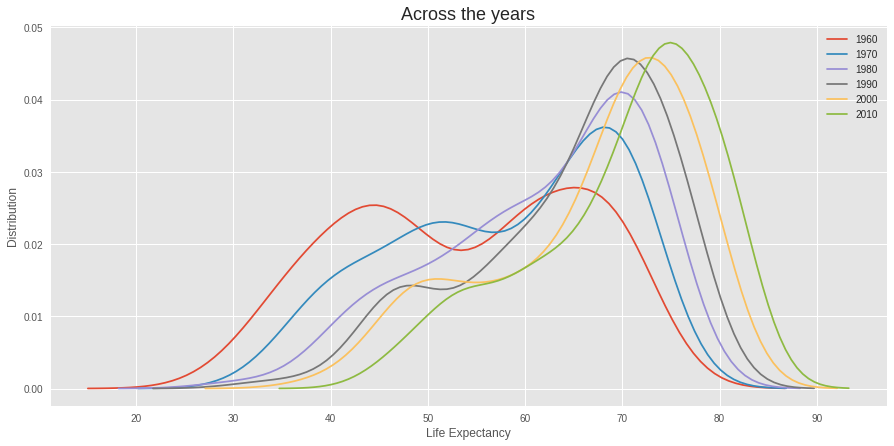

In [26]:
f, ax = plt.subplots(figsize = (15,7))

for year in years:
    data = df[df.year == year]["life"].dropna()
    sns.distplot(data,hist=False, kde=True, rug=False, bins=40, label = str(year));
    
plt.xlabel('Life Expectancy')
plt.ylabel('Distribution')
plt.title("Across the years", fontsize = 18)
plt.show()

In [27]:
df_stacked = df.set_index(["country", "year"]).unstack("year")
df_stacked.head(10)

life                                              \
year                    1960.0     1961.0     1962.0     1963.0     1964.0   
country                                                                      
Afghanistan          31.580049  32.095976  32.611878  33.127317  33.641244   
Albania              62.254366  63.273463  64.162854  64.887098  65.438195   
Algeria              46.135122  46.590317  47.045000  47.496195  47.941902   
American Samoa             NaN        NaN        NaN        NaN        NaN   
Andorra                    NaN        NaN        NaN        NaN        NaN   
Angola               32.984829  33.386220  33.787585  34.188463  34.590341   
Antigua and Barbuda  61.782732  62.195415  62.598537  62.992585  63.378585   
Argentina            65.215537  65.338512  65.432610  65.509390  65.582415   
Armenia              65.863463  66.284390  66.709854  67.137854  67.565415   
Aruba                65.569366  65.988024  66.365537  66.713976  67.044293   

                                                                            \
year                    1965.0     1966.0     1967.0     1968.0     1969.0   
country                                                                      
Afghanistan          34.153683  34.663122  35.170073  35.672024  36.169976   
Albania              65.827390  66.089317  66.287220  66.474951  66.681610   
Algeria              48.376098  48.790805  49.187512  49.572707  49.955902   
American Samoa             NaN        NaN        NaN        NaN        NaN   
Andorra                    NaN        NaN        NaN        NaN        NaN   
Angola               34.992220  35.395098  35.799976  36.205854  36.610244   
Antigua and Barbuda  63.756073  64.125561  64.488073  64.842122  65.189195   
Argentina            65.668683  65.782244  65.930024  66.113488  66.335098   
Armenia              67.991537  68.414732  68.830488  69.229268  69.600049   
Aruba                67.369756  67.699000  68.034683  68.377146  68.728415   

                        ...      population                          \
year                    ...          2004.0      2005.0      2006.0   
country                 ...                                           
Afghanistan             ...      24018682.0  24860855.0  25631282.0   
Albania                 ...       3014579.0   2992724.0   2968028.0   
Algeria                 ...      33461345.0  33960903.0  34507214.0   
American Samoa          ...         59262.0     59117.0     58652.0   
Andorra                 ...         79060.0     81223.0     81877.0   
Angola                  ...      15976715.0  16544376.0  17122409.0   
Antigua and Barbuda     ...         81718.0     82565.0     83467.0   
Argentina               ...      38308779.0  38647854.0  38988923.0   
Armenia                 ...       3025652.0   3014917.0   3002911.0   
Aruba                   ...         98742.0    100031.0    100830.0   

                                                                     \
year                     2007.0      2008.0      2009.0      2010.0   
country                                                               
Afghanistan          26349243.0  27032197.0  27708187.0  28397812.0   
Albania               2940880.0   2912559.0   2884303.0   2856673.0   
Algeria              35097043.0  35725377.0  36383302.0  37062820.0   
American Samoa          57919.0     57053.0     56245.0     55636.0   
Andorra                 81292.0     79969.0     78659.0     77907.0   
Angola               17712824.0  18314441.0  18926650.0  19549124.0   
Antigua and Barbuda     84397.0     85349.0     86300.0     87233.0   
Argentina            39331357.0  39676083.0  40023641.0  40374224.0   
Armenia               2989882.0   2977488.0   2968154.0   2963496.0   
Aruba                  101219.0    101344.0    101418.0    101597.0   

                                                         
year                     2011.0      2012.0      2013.0  
country                         

In [28]:
dff_df = df_stacked['life'].diff(periods = 5 ,axis = 1)
dff_df.head(10)

year,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,1969.0,...,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,2.573634,2.567146,2.558195,2.544707,2.528732,...,2.136854,2.209878,2.314439,2.419488,2.499537,2.542610,2.541659,2.494707,2.417756,NaN
Albania,NaN,NaN,NaN,NaN,NaN,3.573024,2.815854,2.124366,1.587854,1.243415,...,2.045610,1.817317,1.556317,1.306902,1.102951,0.962878,0.889122,0.872683,0.885610,NaN
Algeria,NaN,NaN,NaN,NaN,NaN,2.240976,2.200488,2.142512,2.076512,2.014000,...,0.930927,0.908415,0.887927,0.865780,0.840829,0.811049,0.778000,0.743317,0.711122,NaN
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN,NaN,2.007390,2.008878,2.012390,2.017390,2.019902,...,3.564512,3.334024,3.033902,2.724000,2.454220,2.247512,2.115366,2.052268,2.028268,NaN
Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,1.973341,1.930146,1.889537,1.849537,1.810610,...,1.036024,1.024561,1.010024,0.991390,0.967659,0.940366,0.912049,0.884268,0.860537,NaN
Argentina,NaN,NaN,NaN,NaN,NaN,0.453146,0.443732,0.497415,0.604098,0.752683,...,1.023610,1.006000,0.987537,0.968122,0.948244,0.929366,0.911902,0.897390,0.885780,NaN
Armenia,NaN,NaN,NaN,NaN,NaN,2.128073,2.130341,2.120634,2.091415,2.034634,...,2.207829,2.012024,1.794171,1.562390,1.332902,1.118122,0.931098,0.782366,0.672585,NaN


In [29]:
decline_lexp = (dff_df < 0).sum(axis = 1).sort_values(ascending = False)
decline_lexp.head(30)

country
Ukraine                     21
Belarus                     21
Botswana                    21
Lithuania                   20
Latvia                      20
Zambia                      19
Zimbabwe                    18
Russian Federation          17
Central African Republic    17
Iraq                        16
Kenya                       15
Estonia                     15
Uganda                      14
Swaziland                   14
Bulgaria                    14
Azerbaijan                  13
South Africa                13
Lesotho                     13
Moldova                     12
Cameroon                    12
Armenia                     12
Hungary                     12
Sierra Leone                12
Romania                     11
Namibia                     11
Kazakhstan                  11
Jamaica                     11
Togo                        10
Gabon                       10
Rwanda                      10
dtype: int64

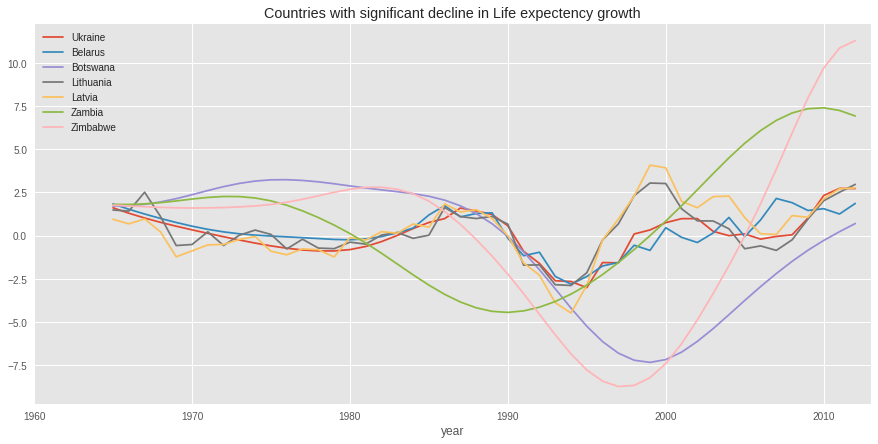

In [30]:
def plot_country(country):
    dff_df.loc[country].plot(figsize = (15,7), label = country)

for country in decline_lexp.head(7).index:
    plot_country(country)
    
plt.title("Countries with significant decline in Life expectency growth")
plt.legend()
plt.show()    

<a id="loadmore"></a>
### D. Add more data 

Add more data about development to the DataFrame. For each data set, you'll include the country and year columns, plus a column that contains the key development variable for that data set. For the employment data set, you'll derive a column from three original columns.

For each of these data sets, get an access key link for the data and paste the link into the appropriate section of the following cell:
* [Population below national poverty line, total, percentage](https://apsportal.ibm.com/exchange/public/entry/view/3a42de810e682d5a83e76fda9fea2bbe)
* [Primary school completion rate % of relevant age group by country](https://apsportal.ibm.com/exchange/public/entry/view/97fc6c420265012ae9b5e9439b9ee293)
* [Total employment, by economic activity (Thousands)](https://apsportal.ibm.com/exchange/public/entry/view/21c789ae4cfadf52f1bb14b5d4a0b99c)
* [Births attended by skilled health staff (% of total) by country](https://apsportal.ibm.com/exchange/public/entry/view/87160cc8374805cb3b07dff4b4f9223e)
* [Measles immunization % children 12-23 months by country](https://apsportal.ibm.com/exchange/public/entry/view/752e36ea889eca360e989baa785c2a5e)

In [31]:
def clean_year(df):
    if df.year.dtype not in (np.int64, np.float64):
        df = df[df.year.apply(lambda x: x.isdigit())]
    df['year'] = df['year'].astype(float)
    return df

In [32]:
# Population below national poverty line, total, percentage
poverty = pd.read_csv("data/UNdata_Export_20151013_112943678-poverty_clean.csv",usecols=['Country or Area', 'Year','Value'])
poverty.columns = ['country', 'year','poverty']

# Primary school completion rate % of relevant age group by country
school = pd.read_csv("data/UNdata_Primary_completion_rate_total (%_relevant_age_group.csv",usecols=['Country or Area', 'Year','Value'])
school.columns = ['country', 'year','school']

# Total employment, by economic activity (Thousands)
employmentin = pd.read_csv("data/Total employment, by economic activity .csv",usecols=['Country or Area', 'Year','Value','Sex','Subclassification'])
employment = employmentin.loc[(employmentin.Sex=='Total men and women')&
                              (employmentin.Subclassification=='Total.')]
employment = employment.drop('Sex', 1)
employment = employment.drop('Subclassification', 1)
employment.columns = ['country', 'year','employment']

# Births attended by skilled health staff (% of total) by country
births = pd.read_csv("data/Births attended by skilled health staff (% of total).csv",usecols=['Country or Area', 'Year','Value'])
births.columns = ['country', 'year','births']

# Measles immunization % children 12-23 months by country
measles = pd.read_csv("data/UNdata_Immunization_measles_%_children_12to23_months.csv",usecols=['Country or Area', 'Year','Value'])
measles.columns = ['country', 'year','measles']


merge_lists = [poverty, school, employment, births, measles]
merge_lists = map(clean_year, merge_lists)

for data in merge_lists:
    print data.info() 
    print ""  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 3 columns):
country    623 non-null object
year       623 non-null float64
poverty    623 non-null float64
dtypes: float64(2), object(1)
memory usage: 19.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5078 entries, 0 to 5077
Data columns (total 3 columns):
country    5078 non-null object
year       5078 non-null float64
school     5078 non-null float64
dtypes: float64(2), object(1)
memory usage: 158.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2909 entries, 0 to 99985
Data columns (total 3 columns):
country       2909 non-null object
year          2909 non-null float64
employment    2909 non-null float64
dtypes: float64(2), object(1)
memory usage: 90.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 3 columns):
country    1468 non-null object
year       1468 non-null float64
births     1467 non-null float64
d

/home/justin/Envs/data_sci/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
df2 = df.copy()
for data in merge_lists:
    df2 = df2.merge(data, how='left', sort=True, on=['country','year'])
    
df2[100:110]

,country,year,life,population,poverty,school,employment,births,measles
100,Albania,2006.0,76.290537,2968028.0,NaN,NaN,935.0,99.0,95.0
101,Albania,2007.0,76.464854,2940880.0,NaN,NaN,NaN,NaN,97.0
102,Albania,2008.0,76.632317,2912559.0,12.4,NaN,NaN,NaN,98.0
103,Albania,2009.0,76.801878,2884303.0,NaN,NaN,NaN,99.3,97.0
104,Albania,2010.0,76.978512,2856673.0,NaN,NaN,NaN,NaN,99.0
105,Albania,2011.0,77.163220,2829337.0,NaN,NaN,NaN,NaN,99.0
106,Albania,2012.0,77.350463,2801681.0,14.3,NaN,NaN,NaN,98.0
107,Albania,2013.0,NaN,2773620.0,NaN,NaN,NaN,NaN,99.0
108,Algeria,1960.0,46.135122,11277757.0,NaN,NaN,NaN,NaN,NaN
109,Algeria,1961.0,46.590317,11560650.0,NaN,NaN,NaN,NaN,NaN


In [43]:
# Normalize Employment Column
df2['employment'] = (df2['employment'] * 1000)/ df2['population']

,country,year,life,population,poverty,school,employment,births,measles
0,Afghanistan,1960.0,31.580049,8774440.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1961.0,32.095976,8953544.0,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1962.0,32.611878,9141783.0,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1963.0,33.127317,9339507.0,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1964.0,33.641244,9547131.0,NaN,NaN,NaN,NaN,NaN


In [44]:
avg_df = df2.groupby('country').mean().sort_values("population",ascending = False)
avg_df.head()

,year,life,population,poverty,school,employment,births,measles
country,,,,,,,,
China,1986.500000,66.247287,1.055207e+09,5.300000,98.367526,0.443804,95.172727,87.645161
India,1986.500000,56.111806,8.224687e+08,33.550000,73.182838,NaN,43.580000,56.482759
United States,1986.500000,74.271993,2.460156e+08,NaN,98.460065,NaN,99.100000,91.617647
Indonesia,1988.393443,61.209935,1.728327e+08,16.242105,87.232905,0.415135,60.028000,67.026316
Russian Federation,1987.952381,67.269271,1.404060e+08,15.884615,92.921962,0.461047,99.258065,94.482759


In [45]:
df2.describe()

,year,life,population,poverty,school,employment,births,measles
count,10174.000000,9200.000000,1.014100e+04,570.000000,3665.000000,2395.000000,1291.000000,5333.000000
mean,1986.723216,63.173605,2.566048e+07,30.746929,77.700596,0.387395,83.867777,76.692293
std,15.507562,11.630020,1.040334e+08,17.937522,27.586450,0.108826,24.182225,22.523123
min,1960.000000,19.504927,5.563000e+03,1.700000,1.522030,0.000027,5.000000,1.000000
25%,1973.000000,54.659305,6.419000e+05,16.900000,59.485630,0.326853,72.700000,65.000000
50%,1987.000000,66.434780,4.325000e+06,25.850000,89.318480,0.392152,98.000000,85.000000
75%,2000.000000,72.039470,1.259322e+07,44.575000,98.092740,0.466632,99.700000,94.000000
max,2013.000000,83.323215,1.357380e+09,96.000000,193.263340,0.729367,100.000000,99.000000


In [99]:
# Extract bottom 30 countries by life expectency 
low_lexp_countries = df2.groupby("country").median().drop('year', axis =1)\
                     .sort_values("life", ascending = True).head(40).index
    
low_lexp_countries

Index([u'Sierra Leone', u'Angola', u'South Sudan', u'Niger', u'Mozambique',
       u'Mali', u'Timor-Leste', u'Rwanda', u'Central African Republic',
       u'Ethiopia', u'Equatorial Guinea', u'Afghanistan', u'Eritrea',
       u'Somalia', u'Malawi', u'Chad', u'Nigeria', u'Guinea', u'Liberia',
       u'Burundi', u'Zambia', u'Guinea-Bissau', u'Uganda', u'Burkina Faso',
       u'Bhutan', u'Lesotho', u'Swaziland', u'Madagascar', u'Tanzania',
       u'Benin', u'Cameroon', u'Nepal', u'Haiti', u'Togo', u'Cambodia',
       u'Comoros', u'Zimbabwe', u'Ghana', u'Botswana', u'Senegal'],
      dtype='object', name=u'country')

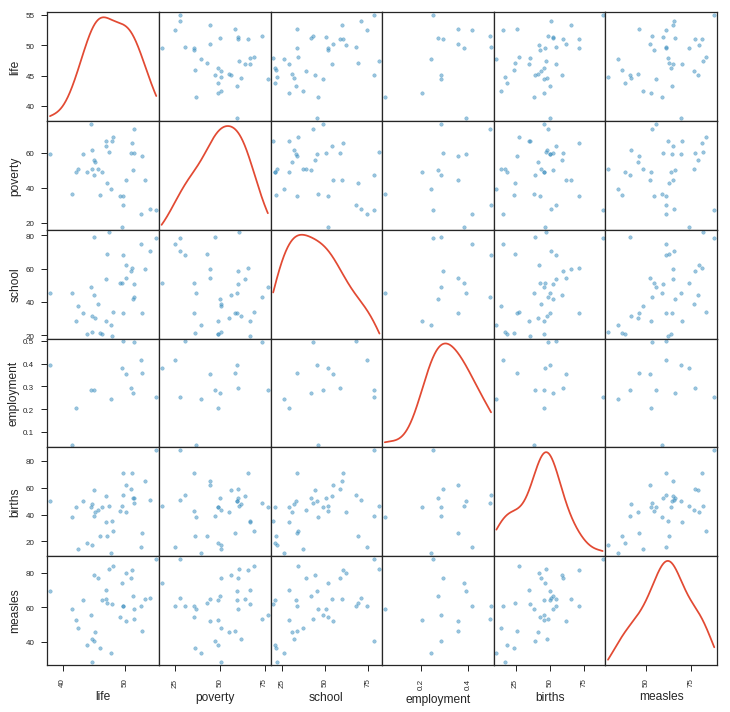

In [100]:
df2_low_avg = df2[df2.country.apply(lambda x:x in list(low_lexp_countries))].groupby('country').mean()
df2_low_avg = df2_low_avg[df2_low_avg.school < df2_low_avg.school.quantile(0.99)]
scatter_matrix(df2_low_avg.drop(['year', 'population'], axis =1),figsize=(12, 12), diagonal='kde');

In [101]:
# from pandas.tools.plotting import scatter_matrix
# # Remove Outliers
# avg_df_trim = avg_df[avg_df.school < avg_df.school.quantile(0.99)]

# scatter_matrix(avg_df_trim.drop(['year', 'population'], axis =1),figsize=(12, 12), diagonal='kde');

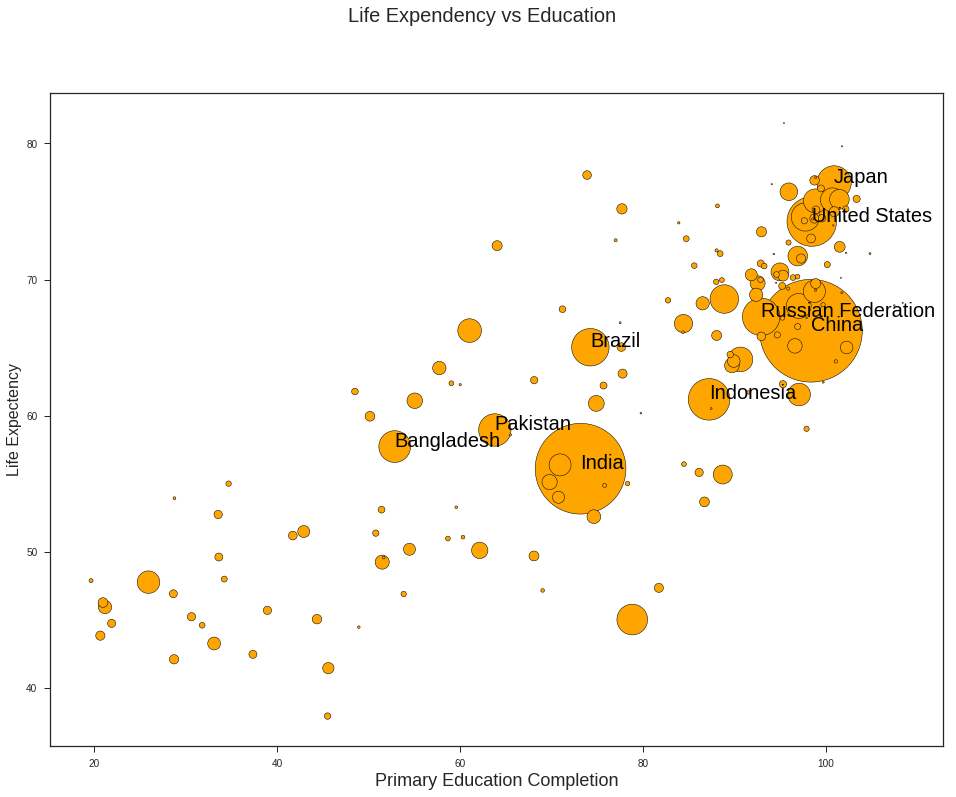

In [59]:
# Plott Scater 
matplotlib.style.use('seaborn-ticks')
fig, ax = plt.subplots()

avg_df_trim.plot.scatter(x='school', y='life', s=avg_df['population']*0.00001,
                         grid = None, color = "orange",
                         figsize=(16,12), edgecolors='black', lw= .5, ax=ax)


# Annotating Top Population
label_threshold = avg_df_trim["population"].quantile(0.95)
for i, txt in enumerate(avg_df_trim.index):
    if avg_df_trim.loc[txt].population > label_threshold:
        ax.annotate(txt, (avg_df_trim.school[i],avg_df_trim.life[i]), size = 20, color = "Black")
    
plt.grid(False)
plt.suptitle('Life Expendency vs Education', fontsize=20)
plt.xlabel('Primary Education Completion', fontsize=18)
plt.ylabel('Life Expectency', fontsize=16)

plt.show()